In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from scipy import interpolate

plt.style.use('seaborn-whitegrid')

In [2]:
columns = ["rad", "rhod", "vel_p", "vel_s", "gacc", "visc"]

In [3]:
def load_model(model_path):
     model_data_array = np.genfromtxt(model_path)
     # radius, density, p-wave vel, s-wave vel, grav accel, viscosity
     model_df = pd.DataFrame(data = model_data_array, columns = ["rad", "rhod", "vel_p", "vel_s", "gacc", "visc"])
     return model_df

def save_model(df, save):
     np.savetxt(save, df[columns].values, fmt=['%16.7e']+['%15.7e']*5)

In [4]:
def plot_model(df, ax=None, xlim=None, type='line'):
    rads = df['rad'].values
    dist = (rads[-1] - rads)/1000
    discont = list(np.diff(dist) == 0)+[False]

    def plot(ax, x, y, type):
        if type == 'line':
            ax.plot(x, y)
        elif type == 'scatter':
            ax.scatter(x, y)

    if ax is None:
        fig, ax = plt.subplots(2,3, figsize=[20,10])
        ax = ax.flatten()
        ax = {columns[idx]: ax[idx] for idx in range(6)}
        
    for idx, item in enumerate(df):
        if item == "visc":
            plot(ax[item], dist, np.log10(df[item]), type)
        else:
            plot(ax[item], dist, df[item], type)
        for d in dist[discont]:
            ax[item].axvline(d, ls="--", color="grey")
        ax[item].set_title(item)
        if xlim is None:
            xlim = [dist.max(),0]
        ax[item].set_xlim(xlim)
    
    return ax

In [5]:
def get_boundary_vals(boundary, array_x, array_y):
    array_x, array_y = np.asarray(array_x), np.asarray(array_y)
    #interp = self.interp_f[item]

    if boundary <= array_x.min():
        return array_y[array_x.argmin()], array_y[array_x.argmin()]

    elif boundary >= array_x.max():
        return array_y[array_x.argmax()], array_y[array_x.argmax()]

    else:
        where_search = np.where(array_x == boundary)[0]
        if len(where_search) == 2:
            # boundary value is already in array as a boundary
            return array_y[where_search[0]], array_y[where_search[1]]
        else: 
            idx = (np.abs(array_x - boundary)).argmin()
            # closest value to boundary
            val = array_x[idx]
            # if value is greater than boundary, need value less than to close boundary
            if val > boundary:
                idx_min, idx_max = idx - 1, idx
            # and vice versa
            elif val < boundary:
                idx_min, idx_max = idx, idx + 1
            else:
                # if on boundary, look for change in value of y
                if array_y[idx-1] != array_y[idx]:
                    idx_min, idx_max = idx - 1, idx
                elif array_y[idx+1] != array_y[idx]:
                    idx_min, idx_max = idx, idx + 1
                else:
                    idx_min, idx_max = idx, idx

            val_min, val_max = array_y[idx_min], array_y[idx_max]
            return val_min, val_max

class ModelGenerator:
    def __init__(self, interp_f, boundaries):
        self.interp_f = interp_f
        self.boundaries = boundaries

        self.core_lm_boundary = 3485500
        self.lm_um_boundary = 5700000
        self.lith_visc = 1e+43

    def generate(self, r, visc_model=None, save=None):
        new_vals = {}
        if visc_model is not None:
            new_vals['visc'] = np.zeros((len(r)))
            for value, r_range in visc_model.items():
                new_vals['visc'][(r>=r_range[0]) & (r<=r_range[1])] = value
                if (r_range[0] not in self.boundaries) and (r_range[0] != 0):
                    self.boundaries.append(r_range[0])
                if (r_range[1] not in self.boundaries)  and (r_range[1] != r[-1]):
                    self.boundaries.append(r_range[1])

        for key, interp in self.interp_f.items():
            if (key == 'visc') & (visc_model is not None):
                total_r_range = r < 0
                for _, r_range in visc_model.items():
                    total_r_range = total_r_range | ((r>=r_range[0]) & (r<=r_range[1]))
                total_r_range = ~total_r_range
                new_vals[key][total_r_range] =  interp(r[total_r_range])
            else:

                new_vals[key] = interp(r)

            if self.boundaries is not None:
                r_boundaries = np.zeros((len(self.boundaries)*2))
                val_boundaries = np.zeros((len(self.boundaries)*2))
            
                for i in range(len(self.boundaries)):
                    boundary = self.boundaries[i]
                    r_boundaries[i*2],r_boundaries[i*2+1] = boundary, boundary

                    if (key == 'visc') & (visc_model is not None):
                        array_x, array_y = r, new_vals[key]
                    else:
                        array_x, array_y = self.interp_f[key].x, self.interp_f[key].y

                    val_boundaries[i*2],val_boundaries[i*2+1] = get_boundary_vals(boundary, array_x, array_y)

                ii = np.searchsorted(r, r_boundaries)
                new_vals[key] = np.insert(new_vals[key], ii, val_boundaries)
        
        if self.boundaries is not None:
            r = np.insert(r, ii, r_boundaries)

        new_vals = {"rad": r} | new_vals

        new_df = pd.DataFrame(data=new_vals, columns=["rad", "rhod", "vel_p", "vel_s", "gacc", "visc"])

        if save:
            np.savetxt(save, new_df.values, fmt=['%16.7e']+['%15.7e']*5)

        return new_df


    def generate_vm(self, r_new, visc_lm, visc_um, lith_thickness, save=None):
        r_max = np.max(self.interp_f['rhod'].x)
        um_lith_boundary = r_max-lith_thickness

        visc_model = {
            visc_lm:[self.core_lm_boundary, self.lm_um_boundary],
            visc_um:[self.lm_um_boundary, um_lith_boundary],
            self.lith_visc :[um_lith_boundary, r_max],
        }

        return self.generate(r=r_new, visc_model=visc_model, save=save)

    @classmethod
    def from_df(cls, df, boundaries=None):
        interp_f = {}
        for item in df:
            if item != "rad":
                interp_f[item] = interpolate.interp1d(df['rad'].values, df[item].values)

        if boundaries == 'auto':
            rads = df['rad'].values
            discont = list(np.diff(rads) == 0)+[False]
            boundaries = list(rads[discont])
            
        return cls(interp_f=interp_f, boundaries=boundaries)

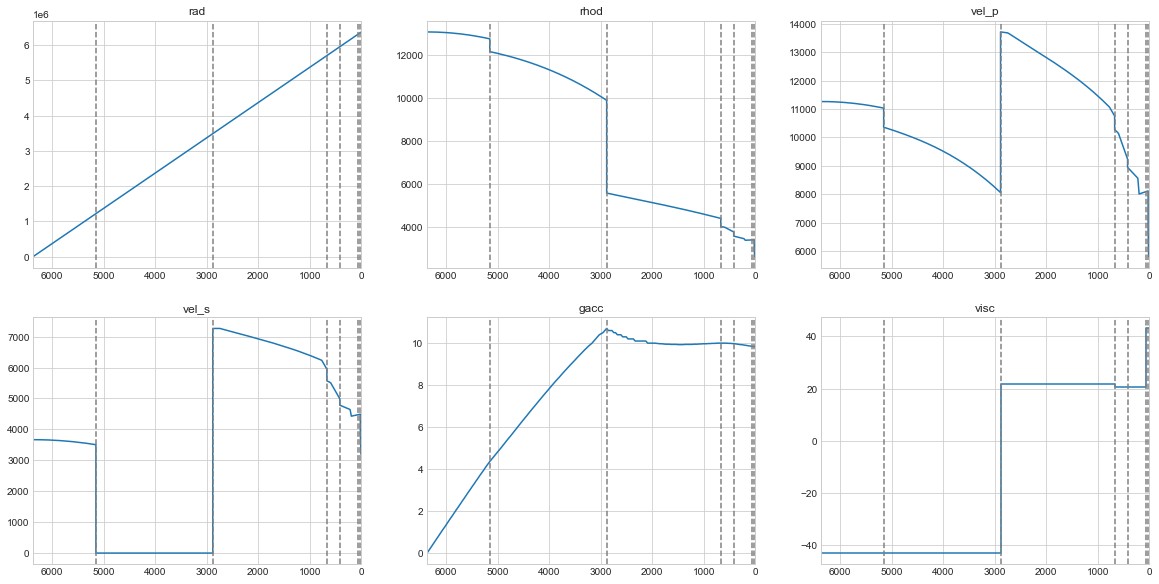

In [6]:
input_file = "../../maxwell_code/MODEL/model.prem.l80.ump5.lm5"
df = load_model(input_file)
ax = plot_model(df)

In [7]:
mg = ModelGenerator.from_df(df, boundaries = 'auto')

In [8]:
def get_boundary_value_positions(array_x, array_y, boundary):
    
    array_x, array_y = np.asarray(array_x), np.asarray(array_y)

    # outside of bounds: less than
    if boundary <= array_x.min():
        left_idx, right_idx = array_x.argmin(), array_x.argmin()
    # outside of bounds: greater than
    elif boundary >= array_x.max():
        left_idx, right_idx = array_x.argmax(), array_x.argmax()
    # inside bounds
    else:
        where_search = np.where(array_x == boundary)[0]
        # inside bounds: value already in array, and is a boundary 
        if len(where_search) == 2:
            left_idx, right_idx = where_search[0], where_search[1]

        # inside bounds: value already in array, but is not a boundary
        elif len(where_search) == 1:
            left_idx, right_idx = where_search[0], where_search[0]

        # inside bounds: value not in array, get values either side
        else: 
            # closest value to boundary
            min_idx = np.abs(array_x - boundary).argmin()
            closest_x = array_x[min_idx] 

            if closest_x < boundary:
                left_x = closest_x
                # check if this is a boundary
                search_idx = np.where(array_x == left_x)[0]
                if len(search_idx) == 2:
                    # this is a boundary, and since it's too the left, take the most right value
                    left_idx = search_idx[-1]
                else:
                    left_idx = search_idx[0]
                right_idx = left_idx + 1
                right_x = array_x[right_idx] 

            else:
                right_x = closest_x
                # check if this is a boundary
                search_idx = np.where(array_x == right_x)[0]
                if len(search_idx) == 2:
                    # this is a boundary, and since it's too the right, take the most left value
                    right_idx = search_idx[0]
                else:
                    right_idx = search_idx[0]
                left_idx = right_idx - 1
                left_x = array_x[left_idx] 
    
    return left_idx, right_idx

In [9]:
def generate(visc_lm, visc_um, lith_thickness, save=None):
    r_max = df['rad'].max()

    um_lith_boundary = r_max - lith_thickness

    visc_model = {
        visc_lm:[mg.core_lm_boundary, mg.lm_um_boundary],
        visc_um:[mg.lm_um_boundary, um_lith_boundary],
        mg.lith_visc :[um_lith_boundary, r_max],
    }

    r_dist = df['rad'].values
    discont = list(np.diff(r_dist) == 0)+[False]
    boundaries = list(r_dist[discont])

    r_dist_new = np.unique(
        np.concatenate([
            np.arange(0, mg.lm_um_boundary, 35*1000),
            np.arange(mg.lm_um_boundary, 6350000.0, 25*1000),
            np.array([6350000.0, 6360500.0, r_max])
        ])
    )

    data_new = {}
    for item in ['rhod', 'vel_p', 'vel_s', 'gacc', 'visc']:
        array_y = df[item].values

        f = interpolate.interp1d(r_dist, array_y)

        r_dist_new_temp = r_dist_new.copy()
        array_y_new = f(r_dist_new_temp)

        for boundary in boundaries:
            # find position of boundary in original data, and get values
            boundary_vals = array_y[np.where(r_dist == boundary)[0]]

            # if the boundary is already in x_new, remove it to replace values with boundary values
            boundary_new_r = np.where(r_dist_new_temp == boundary)[0]
            if len(boundary_new_r) != 0:
                r_dist_new_temp, array_y_new = np.delete(r_dist_new_temp, boundary_new_r), np.delete(array_y_new, boundary_new_r)

            # find where to insert values in new array
            ii = np.searchsorted(r_dist_new_temp, boundary)
            r_dist_new_temp = np.insert(r_dist_new_temp, ii, [boundary, boundary])
            array_y_new = np.insert(array_y_new, ii, boundary_vals)

        data_new[item] = array_y_new

    r_dist_new = r_dist_new_temp

    visc_boundaries = []
    for _, visc_bounds in visc_model.items():
        for boundary in visc_bounds:
            if (boundary not in visc_boundaries) and (boundary not in boundaries) and (boundary != r_max):
                visc_boundaries.append(boundary)

    for item in ['rhod', 'vel_p', 'vel_s', 'gacc', 'visc']:
        r_dist_new_temp = r_dist_new.copy()
        array_y_temp = data_new[item].copy()
        for boundary in visc_boundaries:
            left_boundary_val_idx, right_boundary_val_idx = get_boundary_value_positions(r_dist_new_temp, array_y_temp, boundary)
            boundary_vals = array_y_temp[left_boundary_val_idx], array_y_temp[right_boundary_val_idx]
            ii = np.searchsorted(r_dist_new_temp, boundary)
            array_y_temp = np.insert(array_y_temp, ii, boundary_vals)
            r_dist_new_temp = np.insert(r_dist_new_temp, ii, [boundary, boundary])
        
        data_new[item] = array_y_temp

    r_dist_new = r_dist_new_temp 

    for value, visc_bounds in visc_model.items():
        mod_idx = np.where((r_dist_new>=visc_bounds[0]) & (r_dist_new<=visc_bounds[1]))[0][1:-1]
        data_new['visc'][mod_idx] = value

    data_new['rad'] = r_dist_new
    df_new = pd.DataFrame(data_new)

    if save is not None:
        save_model(df_new, save=save)

    return df_new


In [10]:
"""
upper mantle: 10^20-10^21
lower mantle: 2x10^21-10^23
lithospheric thickness: 50-120
"""

from SALib.sample import latin

problem = {
    'num_vars': 3,
    'names': ['visc_um', 'visc_lm', 'lith_thickness'],
    'bounds': [np.array([10**20, 10**21], dtype=float),
               np.array([2 * 10**21, 10**23], dtype=float),
               np.array([50 * 10**3, 120 * 10**3], dtype=float)]
}

# Generate samples
param_values = latin.sample(problem, 25)

In [11]:
import pandas as pd
pd.DataFrame(data=param_values, columns=problem['names']).to_csv("/nfs/annie/cm15ogp/phd/paper2/global_ice_history/em_exp/param_sample.csv")

In [23]:
! pwd

/nfs/annie/cm15ogp/phd/paper2


In [12]:
output_dir = Path("/nfs/annie/cm15ogp/phd/paper2/global_ice_history/em_exp/em/").resolve()
output_dir.mkdir()

In [13]:
for idx in range(len(param_values)):
    generate(*param_values[idx], save=output_dir / f"{idx}.em")

In [3]:
import subprocess
import time
for idx in range(25):
    cmd = f'''./maxwell_coll_512.x << EOF
    /nfs/annie/cm15ogp/phd/paper2/experiments/em_exp/input/earth_model/{idx}.em
    /nfs/annie/cm15ogp/phd/paper2/experiments/em_exp/input/earth_model/{idx}.model
    lhs_sample_1
    1 3  1 1
    -3.0 1.0 0.25
    4 512 1 1
    -2.5 1.0 0.25
    EOF
    '''

    subprocess.Popen(cmd, cwd="/nfs/annie/cm15ogp/maxwell_code/", shell=True)
    time.sleep(0.5)

In [4]:
cmd = f'''/nfs/annie/cm15ogp/maxwell_code/maxwell_coll_512.x << EOF
/nfs/annie/cm15ogp/phd/paper2/experiments/em_exp/input/earth_model/1.em
/nfs/annie/cm15ogp/phd/paper2/experiments/em_exp/input/earth_model/1.model
lhs_sample_1
1 3  1 1
-3.0 1.0 0.25
4 512 1 1
-2.5 1.0 0.25
EOF
'''

subprocess.Popen(cmd, cwd="/nfs/annie/cm15ogp/maxwell_code/", shell=True)

<Popen: returncode: None args: ['.', '/', 'm', 'a', 'x', 'w', 'e', 'l', 'l',...>

In [21]:
generate(
    np.array([10**20, 10**21], dtype=float).mean(), 
    np.array([2 * 10**21, 10**23], dtype=float).mean(), 
    np.array([50 * 10**3, 120 * 10**3]).mean(), 
    save="/nfs/annie/cm15ogp/phd/paper2/global_ice_history/volume_exp/em.em"
)

,rhod,vel_p,vel_s,gacc,visc,rad
0,13089.000000,11262.000000,3668.000000,0.000000,1.000000e-43,0.0
1,13088.078947,11262.000000,3668.000000,0.128026,1.000000e-43,35000.0
2,13087.155673,11261.155673,3667.155673,0.255517,1.000000e-43,70000.0
3,13086.234211,11260.234211,3666.234211,0.383445,1.000000e-43,105000.0
4,13083.939474,11259.313158,3665.313158,0.510784,1.000000e-43,140000.0
...,...,...,...,...,...,...
199,3377.992000,8096.940000,4482.964000,9.840040,1.000000e+43,6325000.0
200,3381.000000,8113.000000,4492.000000,9.840000,1.000000e+43,6350000.0
201,2900.000000,6800.000000,3900.000000,9.840000,1.000000e+43,6350000.0
202,2600.000000,5800.000000,3200.000000,9.830000,1.000000e+43,6360500.0


In [22]:

cmd = f'''./maxwell_coll_512.x << EOF
/nfs/annie/cm15ogp/phd/paper2/global_ice_history/volume_exp/em.em
/nfs/annie/cm15ogp/phd/paper2/global_ice_history/volume_exp/em.model
lhs_sample_1
1 3  1 1
-3.0 1.0 0.25
4 512 1 1
-2.5 1.0 0.25
EOF
'''

subprocess.Popen(cmd, cwd="/nfs/annie/cm15ogp/maxwell_code/", shell=True)
time.sleep(0.5)

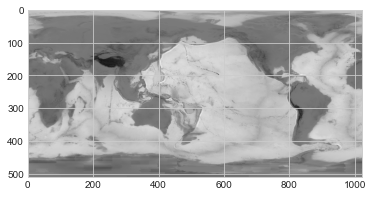

In [24]:
plt.imshow(np.genfromtxt("/nfs/annie/cm15ogp/phd/paper2/topobr"))

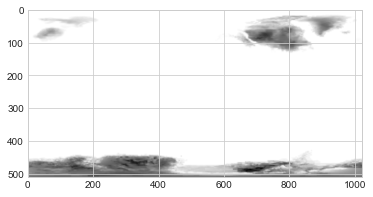

In [23]:
plt.imshow(np.genfromtxt("/nfs/annie/cm15ogp/phd/paper2/global_ice_history/timing_exp/sl/0/ice1"))

In [ ]:
visc_um = 1e+21
visc_lm = 1e+20
lith_thickness = 80 * 1000

In [143]:
np.log10(10^21)

1.4913616938342726

In [137]:
10**20.69897, 10**21.69897

(4.99999995007973e+20, 4.999999950079729e+21)

In [ ]:
lm : 5*10e20
um: 5*10e21

In [141]:
5*10**20

500000000000000000000

In [139]:
0.5*10e21

5e+21

In [ ]:
prem.l80.ump5.lm5

In [134]:
np.log10(0.5*10e21), np.log10(5*10e20)

(21.69897000433602, 21.69897000433602)

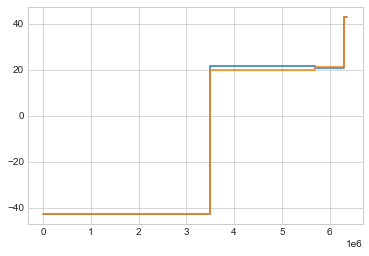

In [31]:
plt.plot(df['rad'], np.log10(df['visc']))
plt.plot(df_new['rad'], np.log10(df_new['visc']))

{'rad': <AxesSubplot:title={'center':'rad'}>,
 'rhod': <AxesSubplot:title={'center':'rhod'}>,
 'vel_p': <AxesSubplot:title={'center':'vel_p'}>,
 'vel_s': <AxesSubplot:title={'center':'vel_s'}>,
 'gacc': <AxesSubplot:title={'center':'gacc'}>,
 'visc': <AxesSubplot:title={'center':'visc'}>}

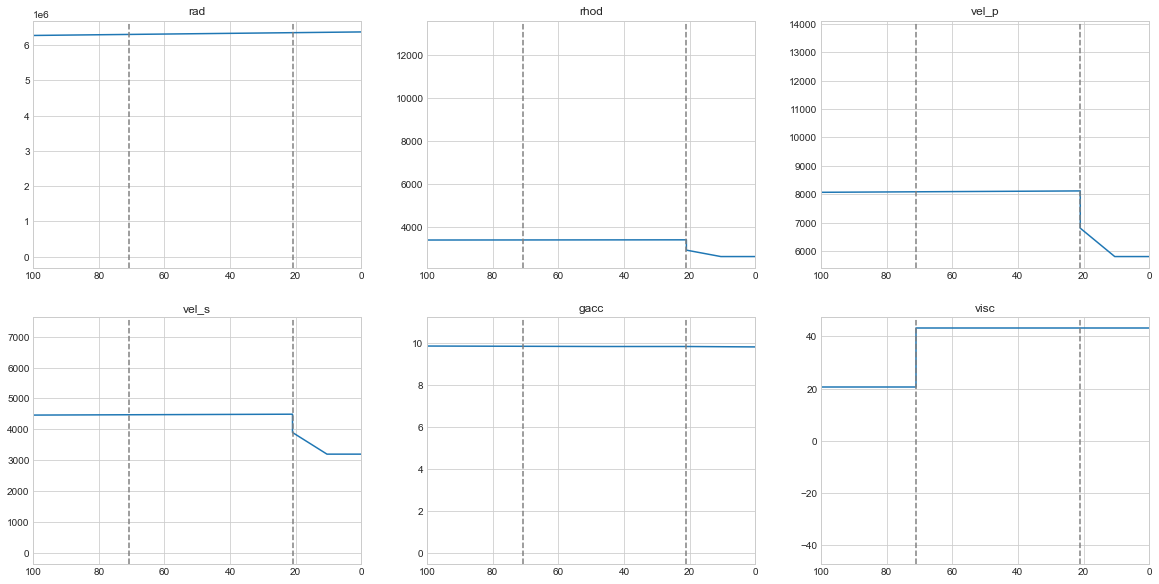

In [35]:
plot_model(df, xlim=[100,0])

In [36]:
df

,rad,rhod,vel_p,vel_s,gacc,visc
0,0.0,13089.0,11262.0,3668.0,0.000,1.000000e-43
1,38000.0,13088.0,11262.0,3668.0,0.139,1.000000e-43
2,75900.0,13087.0,11261.0,3667.0,0.277,1.000000e-43
3,113900.0,13086.0,11260.0,3666.0,0.416,1.000000e-43
4,151900.0,13083.0,11259.0,3665.0,0.554,1.000000e-43
...,...,...,...,...,...,...
157,6325100.0,3378.0,8097.0,4483.0,9.840,1.000000e+43
158,6350000.0,3381.0,8113.0,4492.0,9.840,1.000000e+43
159,6350000.0,2900.0,6800.0,3900.0,9.840,1.000000e+43
160,6360500.0,2600.0,5800.0,3200.0,9.830,1.000000e+43


In [37]:
6371000.0 - 6350000.0

21000.0

{'rad': <AxesSubplot:title={'center':'rad'}>,
 'rhod': <AxesSubplot:title={'center':'rhod'}>,
 'vel_p': <AxesSubplot:title={'center':'vel_p'}>,
 'vel_s': <AxesSubplot:title={'center':'vel_s'}>,
 'gacc': <AxesSubplot:title={'center':'gacc'}>,
 'visc': <AxesSubplot:title={'center':'visc'}>}

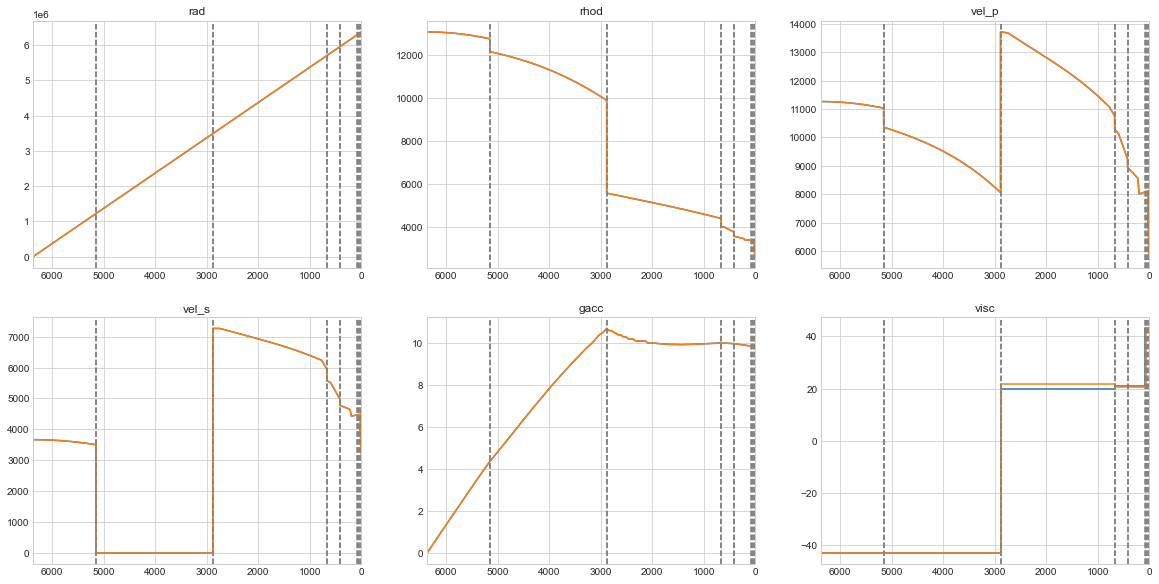

In [11]:
ax = plot_model(df_new)
plot_model(df, ax=ax)

In [13]:
boundaries

[1216800.0, 3485500.0, 5700000.0, 5951000.0, 6300100.0, 6350000.0]

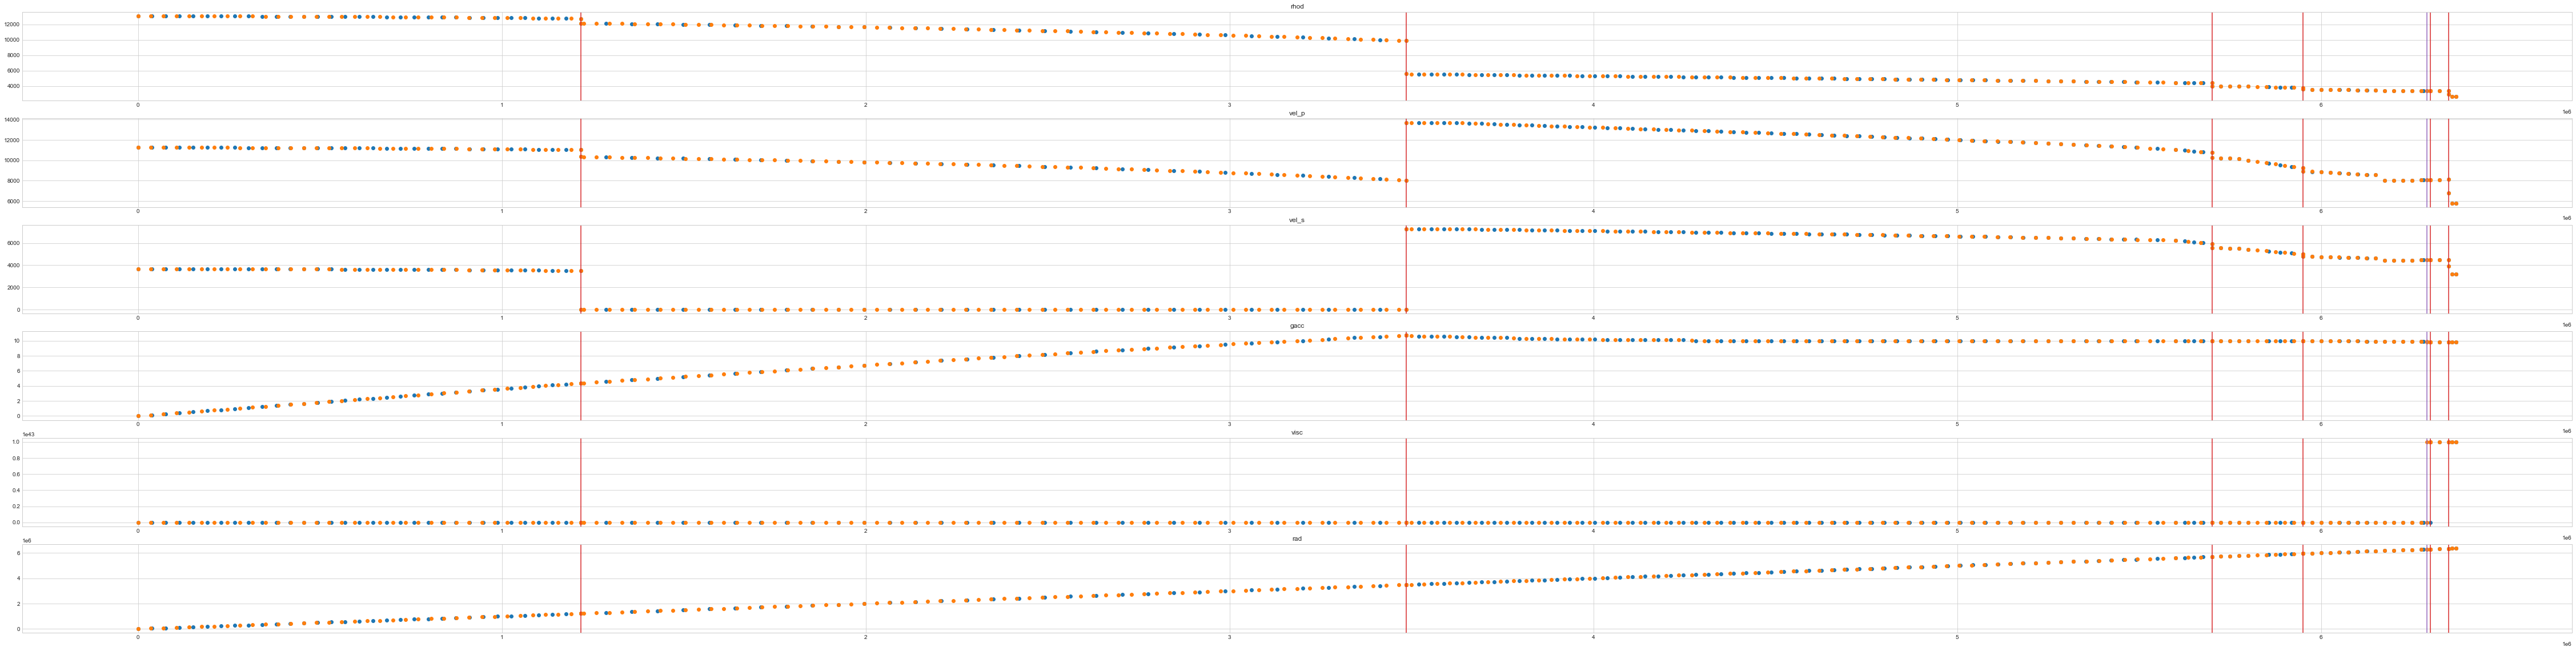

In [41]:
fig, ax = plt.subplots(6,1,figsize=[80,20])
ax = ax.flatten()
for idx, item in enumerate(df_new):
    ax[idx].scatter(df['rad'], df[item])
    ax[idx].scatter(df_new['rad'], df_new[item])
    ax[idx].set_title(item)
    for boundary in boundaries:
        ax[idx].axvline(boundary, color="C3")
    for boundary in visc_boundaries:
        ax[idx].axvline(boundary, color="C4")
fig.savefig("del.png", dpi=300)

AttributeError: 'str' object has no attribute 'axvline'

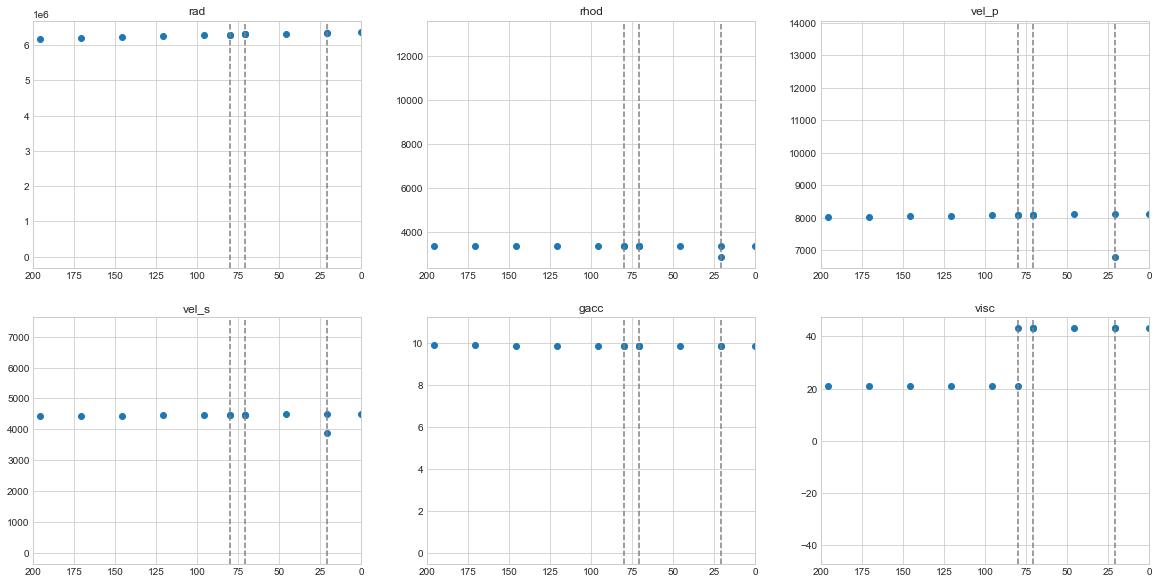

In [10]:
ax = plot_model(df_new, xlim=[200,0], type="scatter")
for axis in ax:
    axis.axvline((r_max - 6321000.0)/1000, color="red")
    axis.axvline((r_max - 6371000.0)/1000, color="red")
plt.show()

In [121]:
r_dist_new = np.unique(
    np.concatenate([
        np.arange(0, mg.core_lm_boundary, 35*1000),
        np.arange(mg.core_lm_boundary, mg.lm_um_boundary, 70*1000),
        np.arange(mg.lm_um_boundary, r_max, 35*1000)
    ])
)
r_dist_new = np.unique(
    np.concatenate([
        np.arange(0, mg.lm_um_boundary, 35*1000),
        np.arange(mg.lm_um_boundary, r_max, 25*1000)
    ])
)

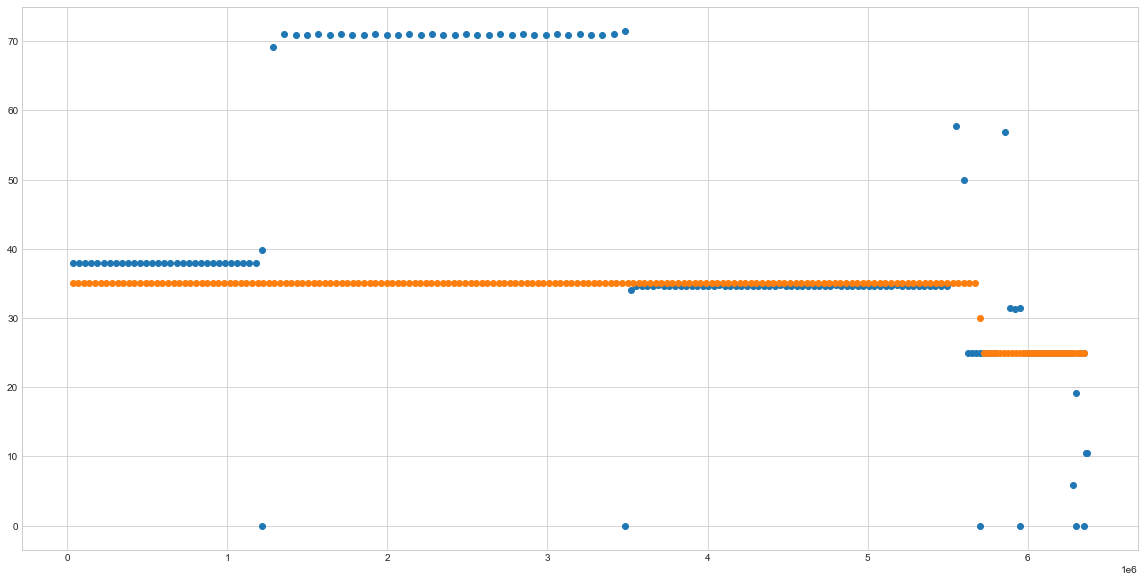

In [122]:
fig, ax = plt.subplots(figsize=[20,10])
ax.scatter(df['rad'].values[1:], np.diff(df['rad'].values/1000))
ax.scatter(r_dist_new[1:], np.diff(r_dist_new/1000))